In [99]:
### The packages needed for this notebook to run through.

import odl
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from select_image import select_image
from select_geometry import geometry_and_ray_trafo
from select_algorithm import algorithm

In [100]:
### Here one loads the image which is used in these classical algorithms. 

### Define your own path to the image.
path = '/home/asalline/Documents/summer2023/algorithms/usable_full_AGD_50_000230.tiff'

### Load the image.
image = cv.imread(path, cv.IMREAD_UNCHANGED)
image = image[90:410, 90:410]
# image = image[0:320:factor, 0:320:factor]

### Normalizing the image and taking its shape.
image = image / np.max(np.max(image))
shape = np.shape(image)

### Fan beam geometry and ray transform:

In the next code section one defines a fan beam geometry which simulates the geometry of the CT-scan. <br>
After when the geometry is defined, one defines a domain for ray transform and ray transform itself.

In [101]:
### There is couple of parameters:

### What kind measurement environment one wants to choose.
### Possible options are 'full', 'sparse', 'limited'.
setup = 'full'

### Factor down amount of the detection lines, must be int.
factor_lines = 2

### Radius from the source to object.
source_radius = 2

### Radius from te object to detector.
detector_radius = 1

if setup == 'full':
    angles = odl.uniform_partition(0, 2*np.pi, 360)
    lines = odl.uniform_partition(-np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'sparse':
    angle_measurements = 100
    line_measurements = int(1024/factor_lines)
    angles = odl.uniform_partition(0, 2*np.pi, angle_measurements)
    lines = odl.uniform_partition(-1*np.pi, np.pi, line_measurements)
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'limited':
    starting_angle = 0
    final_angle = np.pi * 3/4
    angles = odl.uniform_partition(starting_angle, final_angle, 360)
    lines = odl.uniform_partition(-1*np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)


### The domain is defined here, there is couple of parameters:

### Imagine a box in 2D-plane with this parameter being the most southwest point of the box.
min_domain_corner = [-1,-1]

### Imagine a box in 2D-plane with this parameter being the most northeast point of the box.
max_domain_corner = [1,1]

### Number of samples per axis.
shape = shape

### Data type 
dtype = 'float32'

domain = odl.uniform_discr(min_domain_corner, max_domain_corner, shape=shape, dtype=dtype)

### The ray transform is defined here

device = 'astra_cpu'

ray_transform = odl.tomo.RayTransform(domain, geometry, impl=device)

### Sinogram and noise

Next up is using the ray transform to obtain a sinogram from the image. <br>
After that one can/will add there noise, in this notebook Gaussian noise is used.

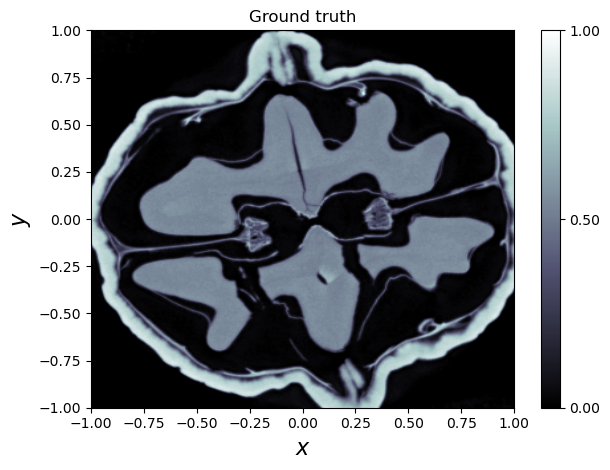

<Figure size 640x480 with 0 Axes>

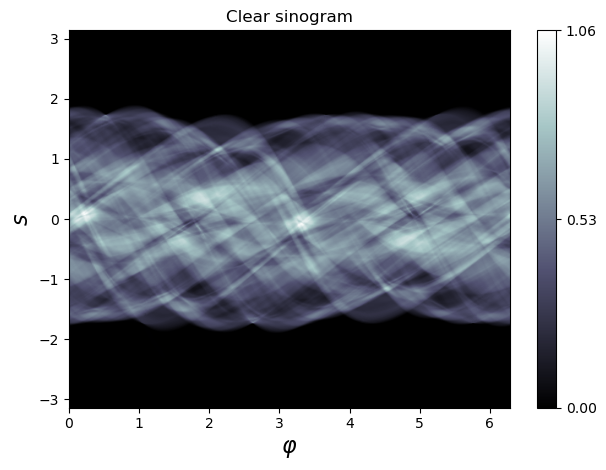

<Figure size 640x480 with 0 Axes>

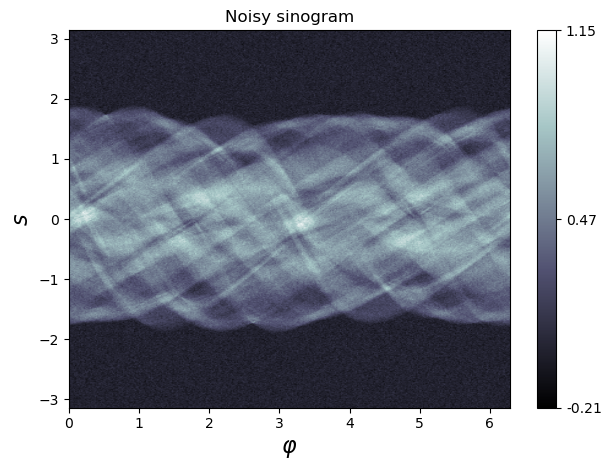

<Figure size 640x480 with 0 Axes>

In [102]:
### First convers image into ODL form
image = domain.element(image)

### Use ray transform to the image to obtain sinogram
sinogram = ray_transform(image)

### Parameters for the Gaussian noise
mean = 0.0
variance = 0.002
sigma = variance ** 0.5

### Create noisy sinogram
noisy_sinogram = sinogram + np.random.normal(mean, sigma, size=(np.shape(sinogram)[0], np.shape(sinogram)[1]))

image.show('Ground truth')
sinogram.show('Clear sinogram')
noisy_sinogram.show('Noisy sinogram')
plt.show()

### Reconstruction methods

Last sections contain different kind of reconstruction algorithms. <br>

### Filtered Back Projection (FBP):

This is the approximate inverse of ray transform. <br>
This is easy to define in the ODL as one can see below.

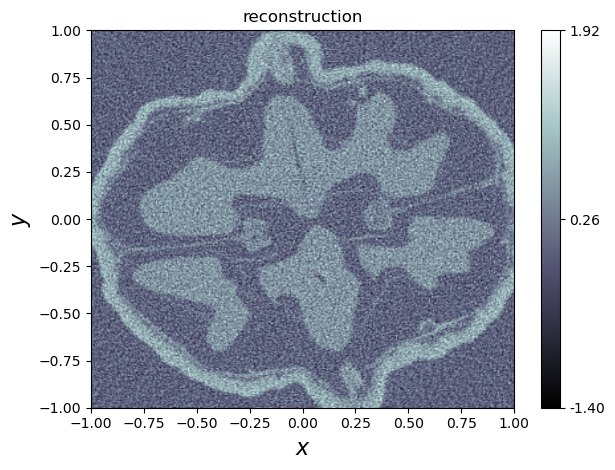

<Figure size 640x480 with 0 Axes>

In [103]:
### There is function in ODL to create FBP operator:
FBP_operator = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo=ray_transform, padding=1)

### One just applies the noisy sinogram with just defined FBP operator and gets a reconstruction out.
reconstruction = FBP_operator(noisy_sinogram)

### Because in these sections the images are plotted in ODL domain the next thing is needed:
reconstruction = domain.element(reconstruction)

### Plotting the reconstructed image
reconstruction.show('reconstruction')
plt.show()

### Tikhonov regularization

This is the first iterative algorithm. It is based on a regularization theory and it is a minimization problem formulated as <br>
$$
\argmin_f \mathcal{E}(f) = \argmin_{f} \{ ||Af - g||^2_2 + \lambda ||Bf||^2_2 \}
$$
Above minimization problem can be understood such that the final answer $f$ should give a good balance between small residual in the first norm and a small value in $L^2$-norm. <br> 
That minimization problem can be solved iteratively with gradient descent. For one to solve the iterative step, the first thing to do is take a derivative of the minimization problem with respect to $f$ and setting it equal to zero. <br>
That then yields an equation which looks like 
$$
\nabla_f \mathcal{E}(f) = (A^T A + \lambda B^T B)f - A^T g
$$
In this case we will also set that $B = I$ and that then gives 
$$
\nabla_f \mathcal{E}(f) = (A^T A + \lambda I)f - A^T g = Tf - b
$$
That equation is now used in the gradient descent such that the iterative step is given as
$$
f_{i+1} = f_i - \beta \nabla_f \mathcal{E}(f_i) = f_i - \beta (T f_i - b)
$$
On below there is then a code with this formulation.

4.47661431035
0.0499000111471
Iteration 0/5


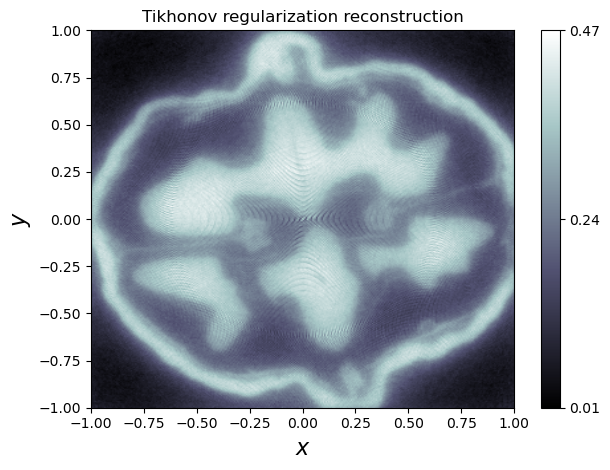

<Figure size 640x480 with 0 Axes>

In [104]:
### Amount of iterative steps
iterations = 5

### Lambda parameter
lam = 0.05

### Renaming ray transform as "operator"
operator = ray_transform

### Defining step size "beta" which is depends on the value of the operator norm
operator_norm = odl.power_method_opnorm(operator)
beta = 1/(operator_norm**2)
print(operator_norm)
print(beta)

### This is how one defines ideneity operator in ODL
id = odl.IdentityOperator(domain)

### Operator "T" defined just as written in equation above
T = operator.adjoint * operator + lam *  id

# Tgrad = operator.adjoint * operator 
# print('T range', T.range)
# print('T domain', T.domain)
# print('sino', noisy_sinogram.shape)

### Evaluating "b" like written above
b = operator.adjoint(noisy_sinogram)

### Starting point f_0 is zero matrix
f_old = domain.zero()

### Here is the iterative loop
for k in range(iterations):
    if k % 50 == 0:
        print(f'Iteration {k}/{iterations}')
    
    ### Iterative step
    f_new = f_old - beta * (T(f_old) - b)
    f_old = f_new

tikhonov_reconstruction = domain.element(f_new)
tikhonov_reconstruction.show('Tikhonov regularization reconstruction')
plt.show()

### Total variation regularization

Here one sets the regularization term to be $\mathcal{R}(f) = || \ |\nabla f| \ ||_1$. Thus the minimization problem becomes then
$$
\argmin_f \mathcal{E}(f) = \argmin_f \{ ||Af - g||^2_2 + \lambda || \ |\nabla f| \ ||_1 \}
$$
This time gradient descent algorithm is unusable, since the regularization term is not differentiable. One overcomes this problem with so called proximal gradient method. <br>
The proximal gradient method is defined as a iteration step
$$
f_{i+1} = \text{prox}_{\mathcal{R}, \beta \lambda} \big( f_i - \beta A^* (A f_i - g) \big)
$$
where $A^* (A f_i - g)$ is just a gradient of the first norm and the proximal operator $\text{prox}_{\mathcal{R}, \beta \lambda}$ is defined as 
$$
\text{prox}_{\mathcal{R}, \beta \lambda}(h) = \argmin_y \{ \beta \lambda \mathcal{R}(y) + \frac{1}{2} || h- y ||^2_2 \}
$$
In the next code section one uses Primal-Dual Hybrid-Gradient (PDHG) algorithm to solve this iterative problem. ODL has very nice feature that calculates proximal operator of the functional (let's say "T") with command "T.proximal". PDHG algorithm relies on that feature and that is why it is suitable to solve this minimization problem. <br>
Before one continues into code, it should be stated that PDHG algorithm is solving the problem in a form of (sorry for he inconvenient notations)
$$
\min_x f(x) + g(Lx)
$$
Here PDHG converges only if $L$ is linear and the primal and dual iteration step lengths $\sigma$ and $\tau$ satisfy that $\sigma \tau ||L||_{operator}^2 < 1$ <br>
Considering imaging problem stated above, one sets $f(x)=0$ and $L(x) = (A(x), \nabla x)$. Then with these settings define $g$ as a function of two variables $g(x_1, x_2) = ||x_1 - y||^2_2 + ||x_2||_1$ which yields then the imaging problem.


/home/asalline/anaconda3/lib/python3.10/site-packages/scipy/sparse/_sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


iter = 0


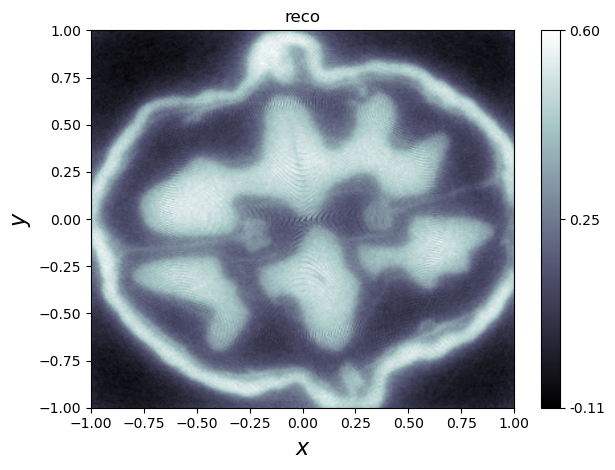

<Figure size 640x480 with 0 Axes>

In [105]:
### First one defines the gradient over the domain of the problem
gradient = odl.Gradient(domain)

### Regularization term penalty constant
lam = 1e-5

### (Column) vector of the operator (ray transform) and the gradient
L = odl.BroadcastOperator(operator, gradient)

### Data consistency term
l2_norm_squared = odl.solvers.L2NormSquared(operator.range).translated(noisy_sinogram)

### Regularization term
l1_norm = lam * odl.solvers.L1Norm(gradient.range)

### Combining the norm-terms
### The order must correspond to formulation!
g = odl.solvers.SeparableSum(l2_norm_squared, l1_norm)

### Setting f(x) = 0
f = odl.solvers.ZeroFunctional(L.domain)

### Selecting optimization parameters tau and lambda
operator_norm_pdhg = 1.1 * operator_norm
tau = 1.0 / operator_norm_pdhg
sigma = tau

### Iteration steps
niter = 5

### Setting a starting point to zero matrix
x = domain.zero()

callback = (odl.solvers.CallbackPrintIteration(step=50))

odl.solvers.pdhg(x, f, g, L, tau = tau, sigma = sigma, niter = niter, callback=callback)

# print(type(x))
# x = x / np.max(np.max(x))
x.show('reco')
plt.show()

Iteration 0/100
Iteration 50/100


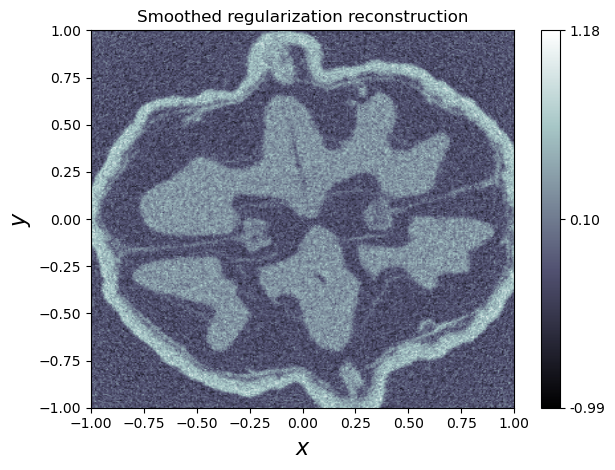

<Figure size 640x480 with 0 Axes>

In [107]:
# print(gradient(x))
# print(odl.Divergence(gradient.range).domain)
# print(np.sqrt(np.sum(np.sum(gradient(x)**2)) + 0.005))
# ones = domain.one()
# id = odl.IdentityOperator(domain)*0.005
# print(x * 0.005)
# print(id(x))
# print(gradient.is_linear)
box = odl.IntervalProd(min_domain_corner, max_domain_corner)
rect_grid = odl.RectGrid(np.linspace(-1,1,shape[0]), np.linspace(-1,1,shape[1]))
rect_part = odl.RectPartition(box, rect_grid)
tensor = odl.space.base_tensors.TensorSpace(shape, dtype='float')
# ones = tensor.one()
discr_space = odl.DiscretizedSpace(rect_part, tensor)
const = domain.one() * (np.sqrt(np.sum(np.sum(gradient(x)**2)) + 0.005))
# print(gradient(x))
# print(const)
# print(gradient(x).is_linear)

# l2_norm_squared = odl.solvers.L2NormSquared(operator.range).translated(noisy_sinogram)

T_1 = 2*operator.adjoint
T_2 = T_1*operator

b = T_1(noisy_sinogram)

division = gradient(x) / const
divergence = -odl.Divergence(gradient.range)
divergence(division)

f_old = domain.zero()

iterations = 100

beta = 1/(operator_norm**2)

lam = 0.005

for k in range(iterations):
    if k % 50 == 0:
        print(f'Iteration {k}/{iterations}')
    
    ### Iterative step
    const = domain.one() * (np.sqrt(np.sum(np.sum(gradient(f_old)**2)) + 0.005))
    division = gradient(f_old) / const
    f_new = f_old - beta * ((T_2(f_old) - b) + lam * divergence(division))
    f_old = f_new


smoothed_reconstruction = domain.element(f_new)
smoothed_reconstruction.show('Smoothed regularization reconstruction')
plt.show()
